In [1]:
# Import modules
import csv
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import talib as ta
from backtesting import Strategy, Backtest
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

c:\Users\林家逸\.virtualenvs\Financial-g_vsQ-6i\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The function of drawing the equity curve and drawdown curve
def figure(strategy):   
    equity_data = strategy._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
    equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

    ax1.grid(linestyle = '--', linewidth = 1)
    ax1.plot(equity_data['Equity'])
    ax1.set(ylabel="Equity($)")
    ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    date_form = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax2.grid(linestyle = '--', linewidth = 1)
    ax2.plot(equity_data['DrawdownPct'], color="red")
    ax2.set(ylabel="DrawdownPct(%)")
    ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
    f.subplots_adjust(hspace=0)
    f.autofmt_xdate()
    f.savefig('output.png')
    plt.show()

In [3]:
# The function of changing the data period
def change_data_period(kbar_df: pd.DataFrame, interval: int):   
    new_kbars_df = kbar_df.copy(deep = True)
    new_kbars_df.index = pd.to_datetime(new_kbars_df.ts)
    
    morning = new_kbars_df.between_time('08:45', '13:45')
    morning = morning.resample(f'{interval}Min', closed = 'right', label = 'right', origin = datetime.datetime(2020, 3, 22, 8, 45)).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        '大戶買進': 'sum',
        '散戶買進': 'sum',
        '大戶掛單': 'sum',
        '散戶掛單': 'sum'
    })
    morning = morning.dropna()

    night = new_kbars_df.between_time('15:00', '5:00')
    night = night.resample(f'{interval}Min', closed = 'right', label = 'right', origin = datetime.datetime(2020, 3, 22, 15, 0)).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        '大戶買進': 'sum',
        '散戶買進': 'sum',
        '大戶掛單': 'sum',
        '散戶掛單': 'sum'
    })
    night = night.dropna()

    return pd.concat([morning, night]).sort_values('ts')

In [4]:
# Constant variables
MORNING_START = datetime.time(9, 30)
MORNING_END = datetime.time(13, 40)
NIGHT_START = datetime.time(15, 45)
NIGHT_END = datetime.time(4, 55)

PLOT_RESULT = False
OPTIMIZE = False

In [5]:
# Deal with the data
stock_data = pd.read_csv('TXF_1T_20240429.csv', encoding = 'utf-8')
stock_data.rename(columns = {'Unnamed: 0': 'ts'}, inplace = True)
stock_data.ts = pd.to_datetime(stock_data.ts)

stock_data_1min = change_data_period(stock_data, 1)

train_data = stock_data_1min.loc['2020-01-01':'2022-12-31']
test_data = stock_data_1min.loc['2023-01-01': ]

In [6]:
# Functions judging if the time is in specific period
def is_morning(time):
    return MORNING_START <= time.time() <= MORNING_END

def is_night(time):
    return time.time() <= NIGHT_END or time.time() >= NIGHT_START

def is_trading_time(time):
    return is_morning(time) or is_night(time)

In [7]:
# Define the strategy
class my_strategy(Strategy):
    do_long = False
    do_short = True
    trade_in_morning = True
    trade_in_night = False

    sl_price = 0
    band_period = 20
    rsv_period = 25
    kd_period = 3

    def init(self):
        self.short_win = 0
        self.long_win = 0
        self.short_lose = 0
        self.long_lose = 0
        self.trade_times = 0
        self.END_TIME = self.data.index[-1]

        self.KDJ = None
        self.is_squeeze = False
        self.open_long_ready = False
        self.open_short_ready = False
        self.sell_ready = False

    def log(self, time):
        if (len(self.closed_trades) != self.trade_times):
            self.trade_times = len(self.closed_trades)

            latest_trade = self.closed_trades[-1]
            profit = latest_trade.pl
            open_time = latest_trade.entry_time
            trade_time = latest_trade.exit_time
            if latest_trade.is_long:
                self.long_win += 1 if profit > 0 else 0
                self.long_lose += 1 if profit <= 0 else 0
                print(f"{'[Win] ' if profit > 0 else '[Lose]'}\t Long trade start at {open_time}, end at {trade_time}, profit: {profit}")
                print('-' * 40)
            else:
                self.short_win += 1 if profit > 0 else 0
                self.short_lose += 1 if profit <= 0 else 0
                print(f"{'[Win] ' if profit > 0 else '[Lose]'}\t  Short trade start at {open_time}, end at {trade_time}, profit: {profit}")
                print('-' * 40)

        if (time == self.END_TIME):
            print(f'Long Win: {self.long_win}, Long Lose: {self.long_lose}, Total_long_trades: {self.long_win + self.long_lose}')
            print(f'Short Win: {self.short_win}, Short Lose: {self.short_lose}, Total_short_trades: {self.short_win + self.short_lose}')

    def supertrend(self, high, low, close, period, multiplier, prev_info):
        supertrend_data = {
            'value': None,
            'trend': None,
            'signal': None
        }
        
        hl2 = (high + low) / 2
        close_left_shift = close[ : -1] 
        atr = max(high - low, abs(high - close_left_shift), abs(low - close_left_shift))
        
        up = hl2 - (multiplier * atr)
        up1 = up[-2] if up[-2] is not None else up[-1]
        up = max(up[-1], up1) if close[-2] > up1 else up[-1]

        dn = hl2 + (multiplier * atr)
        dn1 = dn[-2] if dn[-2] is not None else dn[-1]
        dn = min(dn[-1], dn1) if close[-2] < dn1 else dn[-1]
        
        trend = prev_info['trend'] if prev_info is not None else 1
        if trend == -1 and close[-1] > dn1:
            trend = 1
        elif trend == 1 and close[-1] < up1:
            trend = -1
        else:
            trend = trend
        supertrend_data['trend'] = trend

        if prev_info is None:
            supertrend_data['signal'] = 'buy' if trend == 1 else 'sell'
        elif trend == 1 and prev_info['trend'] == -1:
            supertrend_data['signal'] = 'buy'
        elif trend == -1 and prev_info['trend'] == 1:
            supertrend_data['signal'] = 'sell'
        else:   
            supertrend_data['signal'] = 'wait'

        if trend == 1:
            supertrend_data['value'] = up
        else:
            supertrend_data['value'] = dn

        return supertrend_data        

    def kdj(self, high, low, close, period, signal_k, signal_d, prev_info):
        return_data = {
            'k': None,
            'd': None,
            'j': None,
            'rsv': None,
            'high': None,
            'low': None,
            'close': None
        }
        _alpha_k = 2 / (signal_k + 1)
        _alpha_d = 2 / (signal_d + 1)

        high = high[-period - 1 : ]
        low = low[-period - 1 : ]
        close = close[-period - 1 : ]

        rsv = int((close[-1] - min(low)) / (max(high) - min(low)) * 100 + 0.5 if max(high) - min(low) != 0 else 0)

        last_k = prev_info['k'] if prev_info is not None else 50
        cur_k = int(_alpha_k * ((last_k + 2 * rsv) / 3) + (1 - _alpha_k) * last_k + 0.5)

        last_d = prev_info['d'] if prev_info is not None else 50
        cur_d = int(_alpha_d * ((last_d + 2 * cur_k) / 3) + (1 - _alpha_d) * last_d + 0.5)

        cur_j = 3 * cur_k - 2 * cur_d

        return_data['k'] = cur_k
        return_data['d'] = cur_d
        return_data['j'] = cur_j
        return_data['rsv'] = rsv
        return_data['high'] = max(high)
        return_data['low'] = min(low)
        return_data['close'] = close[-1]

        return return_data

    def next(self):
        time = self.data.index[-1]
        self.log(time)
        self.KDJ = self.kdj(self.data.High[-30 : ], self.data.Low[-30 : ], self.data.Close[-30 : ], self.rsv_period, self.kd_period, self.kd_period, self.KDJ)
        # if time.date() >= datetime.date(2024, 4, 20):
        #     print(time, self.KDJ)

        if not is_trading_time(time):   # return if not in trading time
            return
        if time.time() == MORNING_END or time.time() == NIGHT_END:  # close all positions at the end of the trading time
            self.is_squeeze = False
            self.open_long_ready = False
            self.open_short_ready = False
            self.sell_ready = False

            self.position.close()
            self.orders.cancel()
            return
        
        # Calculate the indicators
        close_bband_mid = ta.SMA(self.data.Close[-30 : ], timeperiod = self.band_period)
        close_stddev = ta.STDDEV(self.data.Close[-30 : ], timeperiod = self.band_period)
        close_bband_up = close_bband_mid + 2 * close_stddev
        close_bband_down = close_bband_mid - 2 * close_stddev

        close_keltner_mid = ta.EMA(self.data.Close[-30 : ], timeperiod = self.band_period)
        close_tr = np.array([])
        for i in range(1, 30):
            tr = max(
                self.data.High[-i] - self.data.Low[-i],
                abs(self.data.High[-i] - self.data.Close[-i - 1]),
                abs(self.data.Low[-i] - self.data.Close[-i - 1])
            )   
            close_tr = np.append(tr, close_tr)  
        close_tr = np.append(0, close_tr) 
        close_tr_ema = ta.EMA(close_tr, timeperiod = self.band_period)
        close_keltner_up = close_keltner_mid + 1.5 * close_tr_ema
        close_keltner_down = close_keltner_mid - 1.5 * close_tr_ema


        big_buyer_amount_rsi = ta.RSI(
            self.data.大戶買進[-30 : ],
            timeperiod = self.rsv_period
        )

        if close_bband_up[-1] <= close_keltner_up[-1] and close_bband_down[-1] >= close_keltner_down[-1]:   # Check if the market is in a squeeze
            self.is_squeeze = True
            self.open_long_ready = False
            self.open_short_ready = False
        else:
            self.is_squeeze = False

        if self.trade_in_morning and is_morning(time):  # trading in the morning
            if self.position.size == 0:
                if self.is_squeeze:
                    if self.data.Close[-1] < close_bband_down[-1] and self.KDJ['j'] < 20:
                        self.open_long_ready = True

                    if self.data.Close[-1] > close_bband_up[-1] and self.KDJ['j'] > 80:
                        self.open_short_ready = True

                if self.open_long_ready and self.do_long:
                    if self.KDJ['j'] > 20 and self.data.Close[-1] > self.data.Open[-1] and big_buyer_amount_rsi[-1] > 20:
                        self.sl_price = min(self.data.Low[-1], self.data.Low[-2], self.data.Low[-3], self.data.Low[-4], self.data.Low[-5])
                        self.buy(size = 200, limit = self.data.Close[-1], stop = self.sl_price) 
                        self.sell_ready = False
                        return

                if self.open_short_ready and self.do_short:
                    if self.KDJ['j'] < 80 and self.data.Close[-1] < self.data.Open[-1] and big_buyer_amount_rsi[-1] < 80:
                        self.sl_price = max(self.data.High[-1], self.data.High[-2], self.data.High[-3], self.data.High[-4], self.data.High[-5])
                        self.sell(size = 200, limit = self.data.Close[-1], stop = self.sl_price)
                        self.sell_ready = False
                        return

            elif self.position.is_long:
                if self.KDJ['j'] > 80 and big_buyer_amount_rsi[-1] > 80:
                    self.sell_ready = True
                    return
                
                elif self.sell_ready or self.data.Close[-1] < self.sl_price: 
                    self.position.close()
                    self.sell_ready = False
                    return
                    
            elif self.position.is_short:
                if self.KDJ['j'] < 20 and big_buyer_amount_rsi[-1] < 20:
                    self.sell_ready = True
                    return
                
                elif self.sell_ready or self.data.Close[-1] > self.sl_price:
                    self.position.close()
                    self.sell_ready = False
                    return

        if self.trade_in_night and is_night(time):      # trading in the night
            if self.position.size == 0:
                if self.is_squeeze:
                    if self.data.Close[-1] < close_bband_down[-1] and self.KDJ['j'] < 20:
                        self.open_long_ready = True

                    if self.data.Close[-1] > close_bband_up[-1] and self.KDJ['j'] > 80:
                        self.open_short_ready = True

                if self.open_long_ready and self.do_long:
                    if self.KDJ['j'] > 20 and self.data.Close[-1] > self.data.Open[-1] and big_buyer_amount_rsi[-1] > 20:
                        self.sl_price = min(self.data.Low[-1], self.data.Low[-2], self.data.Low[-3], self.data.Low[-4], self.data.Low[-5])
                        self.buy(size = 200, limit = self.data.Close[-1], stop = self.sl_price) 
                        self.sell_ready = False
                        return

                if self.open_short_ready and self.do_short:
                    if self.KDJ['j'] < 80 and self.data.Close[-1] < self.data.Open[-1] and big_buyer_amount_rsi[-1] < 80:
                        self.sl_price = max(self.data.High[-1], self.data.High[-2], self.data.High[-3], self.data.High[-4], self.data.High[-5])
                        self.sell(size = 200, limit = self.data.Close[-1], stop = self.sl_price)
                        self.sell_ready = False
                        return

            elif self.position.is_long:
                if self.KDJ['j'] > 80 and big_buyer_amount_rsi[-1] > 80:
                    self.sell_ready = True
                    return
                
                elif self.sell_ready or self.data.Close[-1] < self.sl_price: 
                    self.position.close()
                    self.sell_ready = False
                    return
                    
            elif self.position.is_short:
                if self.KDJ['j'] < 20 and big_buyer_amount_rsi[-1] < 20:
                    self.sell_ready = True
                    return
                
                elif self.sell_ready or self.data.Close[-1] > self.sl_price:
                    self.position.close()
                    self.sell_ready = False
                    return

In [8]:
# Backtest
bt = Backtest(train_data, my_strategy, cash = 500_000, commission = 0.00025, hedging = False, exclusive_orders = False, margin = 0.05)
stats = bt.run()

[Lose]	  Short trade start at 2020-03-31 10:22:00, end at 2020-03-31 10:25:00, profit: -1881.5999999998894
----------------------------------------
[Win] 	  Short trade start at 2020-03-31 10:38:00, end at 2020-03-31 13:41:00, profit: 15316.649999999936
----------------------------------------
[Lose]	  Short trade start at 2020-04-06 12:21:00, end at 2020-04-06 13:32:00, profit: -1689.04999999977
----------------------------------------
[Lose]	  Short trade start at 2020-04-08 12:07:00, end at 2020-04-08 12:16:00, profit: -1703.5499999998137
----------------------------------------
[Lose]	  Short trade start at 2020-04-08 12:32:00, end at 2020-04-08 12:36:00, profit: -1104.950000000099
----------------------------------------
[Lose]	  Short trade start at 2020-04-09 11:58:00, end at 2020-04-09 12:04:00, profit: -705.0500000001193
----------------------------------------
[Lose]	  Short trade start at 2020-04-09 12:08:00, end at 2020-04-09 12:58:00, profit: -1105.500000000029
-----------

In [9]:
# Print the result of backtest
print(stats)

Start                     2020-03-22 08:46:00
End                       2022-12-31 05:00:00
Duration                   1013 days 20:14:00
Exposure Time [%]                    2.167213
Equity Final [$]                   1656592.95
Equity Peak [$]                    1656992.95
Return [%]                          231.31859
Buy & Hold Return [%]               55.980967
Return (Ann.) [%]                    43.99111
Volatility (Ann.) [%]               16.029736
Sharpe Ratio                         2.744344
Sortino Ratio                       17.653525
Calmar Ratio                         7.020268
Max. Drawdown [%]                   -6.266301
Avg. Drawdown [%]                    -0.41243
Max. Drawdown Duration       48 days 20:47:00
Avg. Drawdown Duration        1 days 21:04:00
# Trades                                  510
Win Rate [%]                        38.039216
Best Trade [%]                       1.078186
Worst Trade [%]                     -0.253828
Avg. Trade [%]                    

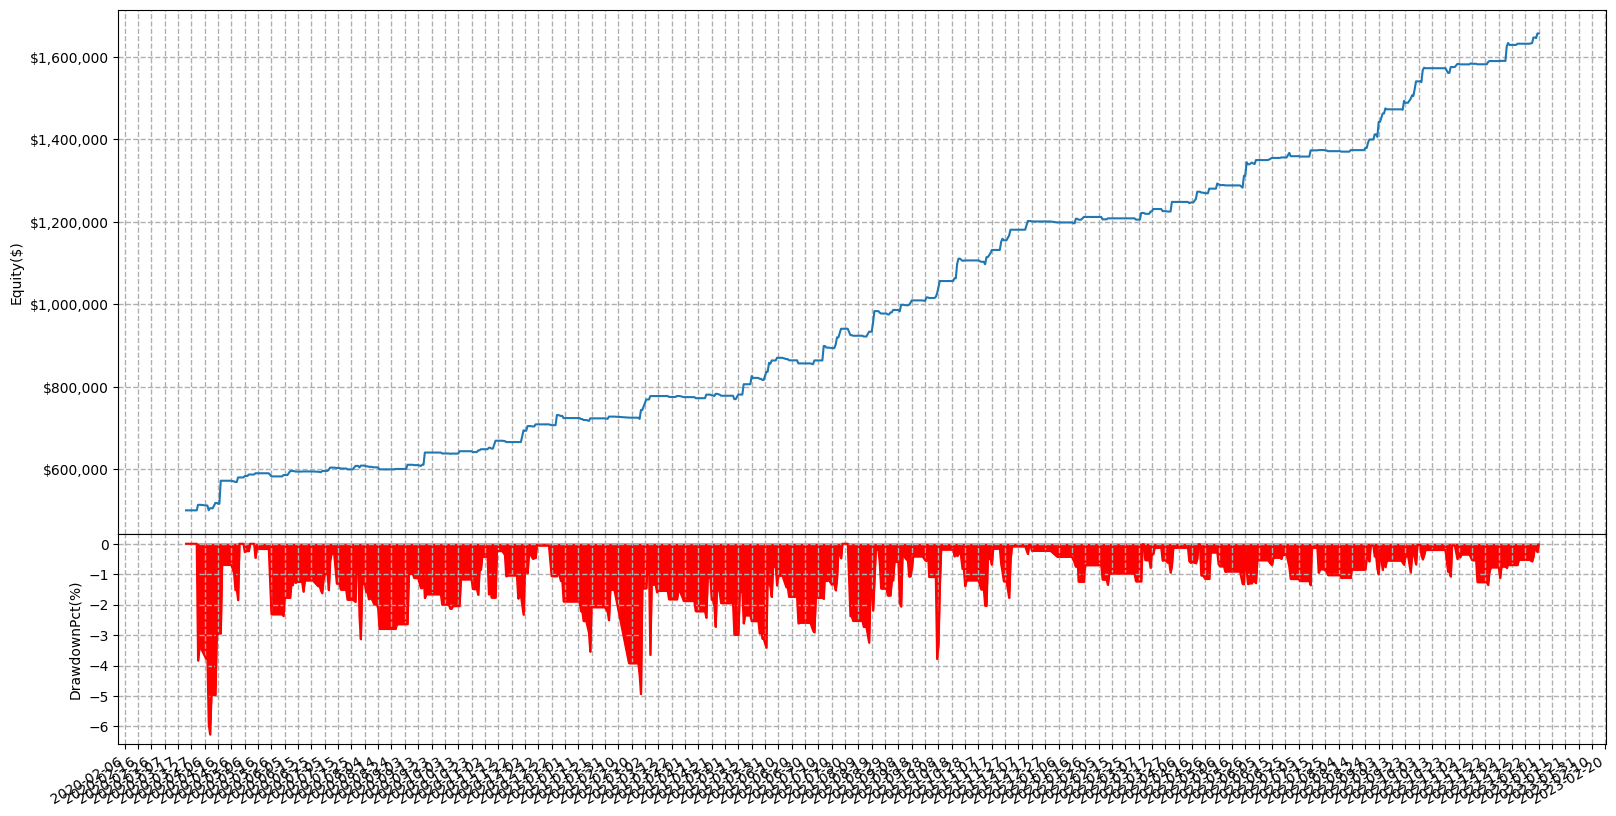

In [10]:
# Draw the equity curve and drawdown curve
figure(stats)

In [11]:
# Plot the trading signals if needed
if PLOT_RESULT:
    bt.plot(plot_pl = False, superimpose = False, resample = False)

In [12]:
# Optimize the strategy
if OPTIMIZE:
    stats_op = bt.optimize(
        band_period = range(10, 50, 5),
        rsv_period = range(10, 50, 5),
        kd_period = range(2, 5, 1),
    )

In [13]:
# Print the result of optimization
if OPTIMIZE:
    print(stats_op)
    print(stats_op._strategy)

In [14]:
# Validate the strategy
bt = Backtest(test_data, my_strategy, cash = 500_000, commission = 0.00025, hedging = False, exclusive_orders = False, margin = 0.05)
stats = bt.run()

[Lose]	  Short trade start at 2023-01-03 11:38:00, end at 2023-01-03 12:01:00, profit: -1709.7499999999854
----------------------------------------
[Win] 	  Short trade start at 2023-01-05 11:00:00, end at 2023-01-05 11:49:00, profit: 6685.000000000218
----------------------------------------
[Win] 	  Short trade start at 2023-01-05 11:50:00, end at 2023-01-05 11:58:00, profit: 2286.6500000000087
----------------------------------------
[Lose]	  Short trade start at 2023-01-05 11:59:00, end at 2023-01-05 12:03:00, profit: -912.749999999869
----------------------------------------
[Lose]	  Short trade start at 2023-01-05 12:06:00, end at 2023-01-05 12:21:00, profit: -913.0000000001019
----------------------------------------
[Lose]	  Short trade start at 2023-01-05 12:29:00, end at 2023-01-05 12:46:00, profit: -913.3999999998196
----------------------------------------
[Lose]	  Short trade start at 2023-01-09 09:57:00, end at 2023-01-09 10:46:00, profit: -1533.2500000000437
------------

In [15]:
# Print the result of validation
print(stats)

Start                     2023-01-03 08:46:00
End                       2024-04-27 05:00:00
Duration                    479 days 20:14:00
Exposure Time [%]                    2.227845
Equity Final [$]                    673391.25
Equity Peak [$]                     678442.25
Return [%]                           34.67825
Buy & Hold Return [%]                44.16287
Return (Ann.) [%]                   21.913501
Volatility (Ann.) [%]               14.298352
Sharpe Ratio                         1.532589
Sortino Ratio                        5.284952
Calmar Ratio                         3.657754
Max. Drawdown [%]                   -5.990972
Avg. Drawdown [%]                   -0.836084
Max. Drawdown Duration       73 days 00:33:00
Avg. Drawdown Duration        4 days 04:07:00
# Trades                                  248
Win Rate [%]                        27.822581
Best Trade [%]                       0.792969
Worst Trade [%]                     -0.131945
Avg. Trade [%]                    

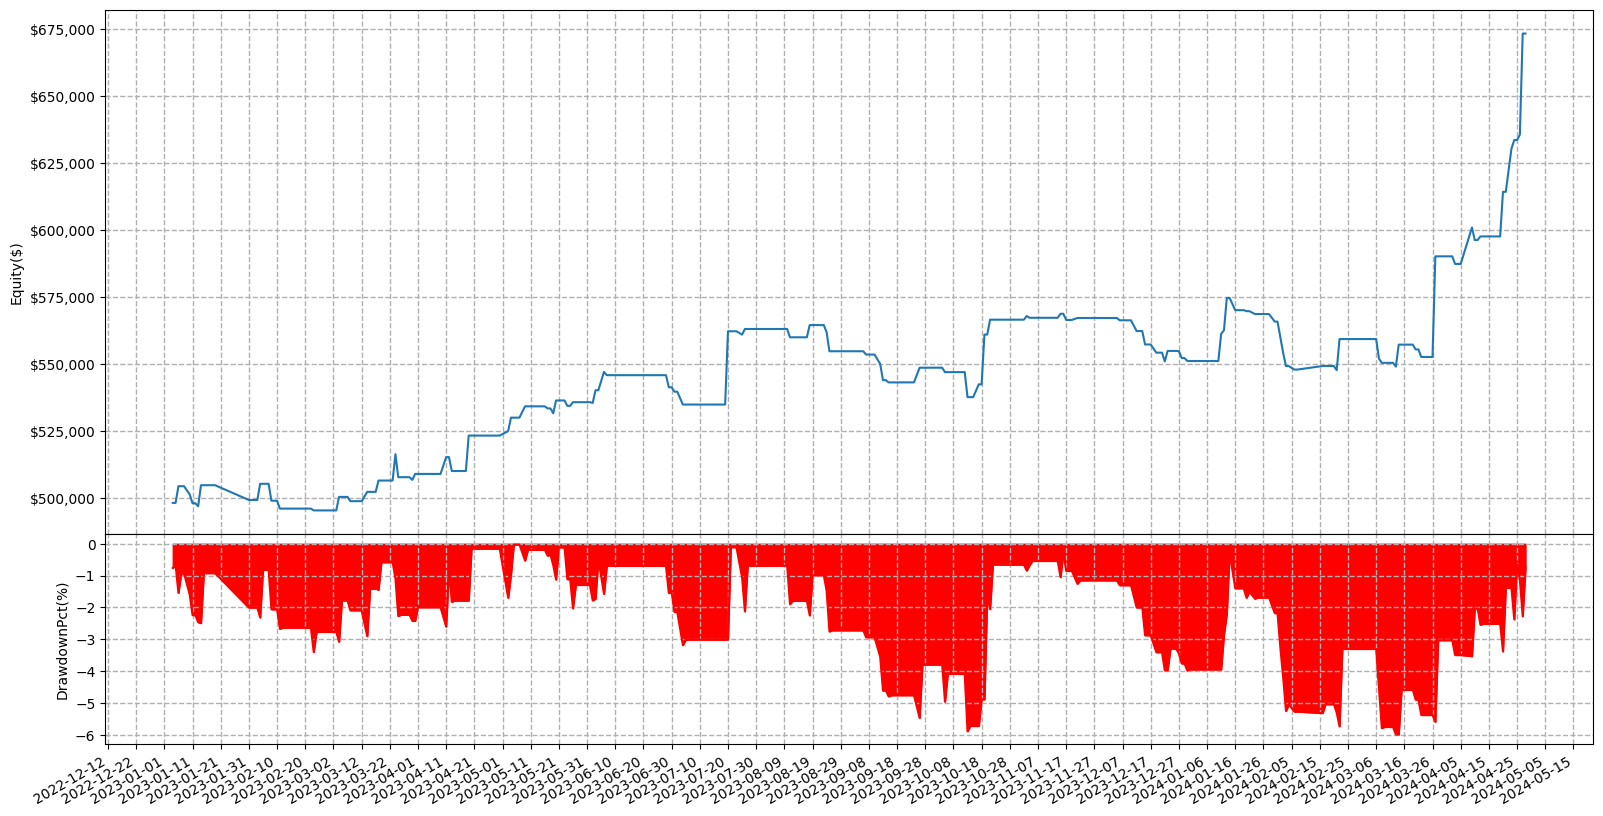

In [16]:
# Draw the equity curve and drawdown curve
figure(stats)